# Import necessary libraries

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import pickle

from train import return_vif
from train import calculate_r_squared, scale_data
from train import print_ols_summary, process_data_using_vif

# Loading data and do some quick checks

As the convention used by us, this file is in fact a `.tsv` file, not a `.csv` one.

In [35]:
data = pd.read_csv('~/Downloads/train_set.csv', sep='\t')
data.drop("ID", axis=1, inplace=True)
data.describe()

,Log price (1 billion VND),Log area (square meters),Bedrooms,WC,Parking,For rent,Infrastructure,Facade,Number of floors,Log usable area (square meters),Latitude,Longitude,Cluster,Distance to center 0,Distance to center 1,Distance to center 2,Distance to center 3,Distance to center 4
count,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,1.786750,4.126558,3.930103,3.822481,0.440568,0.093669,0.689276,0.359173,3.293669,5.183102,14.549952,106.502293,1.671835,736.185477,427.014261,576.701726,730.070664,546.017454
std,0.641023,0.537527,2.323194,2.160481,0.496616,0.291462,0.462939,0.479913,1.830058,0.711515,4.786508,0.627924,1.000094,485.943430,528.158846,118.767979,526.978047,349.279080
min,0.095310,1.386294,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.610070,9.187031,103.840727,0.000000,0.742844,0.255778,6.776643,0.059829,26.760797
25%,1.360977,3.737670,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.762174,10.794919,105.861709,1.000000,92.417575,6.061974,592.317789,8.532486,291.058317
50%,1.704748,4.094345,4.000000,4.000000,0.000000,0.000000,1.000000,0.000000,3.000000,5.178967,10.856744,106.644527,1.000000,1110.863211,12.356436,603.766341,1134.250822,298.042734
75%,2.140066,4.430817,4.000000,4.000000,1.000000,0.000000,1.000000,1.000000,4.000000,5.598422,20.979961,106.710731,3.000000,1117.719338,1134.968917,612.194060,1140.700321,1024.497596
max,3.555348,6.109248,45.000000,48.000000,1.000000,1.000000,1.000000,1.000000,28.000000,8.630522,22.340714,109.200154,4.000000,1306.599741,1317.446936,834.282072,1317.684273,1243.444574


In [36]:
data["Log Bedrooms"] = np.log(data["Bedrooms"])
data["Log WC"] = np.log(data["WC"])
data["Log Floors"] = np.log(data["Number of floors"])
data.drop(columns=["Bedrooms", "WC", "Number of floors", "Latitude", "Longitude", 'Log usable area (square meters)'], inplace=True)

In [37]:
data = scale_data(data)

As preprocessed by the DE team, the model has quite good standard deviation across all features, in other word, they did their homework well, with the boxplot.

Now, let's have a look at some first columns.

In [38]:
data.head()

,Log price (1 billion VND),Log area (square meters),Parking,For rent,Infrastructure,Facade,Cluster,Distance to center 0,Distance to center 1,Distance to center 2,Distance to center 3,Distance to center 4,Log Bedrooms,Log WC,Log Floors
0,-0.530310,-1.288856,-0.887428,-0.321481,0.671414,-0.748655,1.328469,-1.322585,1.351765,0.172328,-1.380141,1.388260,-0.493578,0.323821,1.033543
1,1.518783,-0.637139,-0.887428,-0.321481,-1.489394,-0.748655,0.328240,-0.371706,0.343096,-4.732391,-0.235886,-0.330580,-0.493578,-1.312694,-0.679309
2,-0.767807,0.330336,1.126852,-0.321481,0.671414,1.335729,-0.671988,0.764754,-0.784488,0.192896,0.762074,-0.764218,0.262754,0.323821,-0.679309
3,-0.130805,-1.349877,-0.887428,-0.321481,-1.489394,1.335729,-0.671988,0.778967,-0.798698,0.279746,0.772966,-0.718391,-1.559568,-1.312694,-0.876262
4,-0.099847,-0.362392,1.126852,-0.321481,-1.489394,-0.748655,-0.671988,0.788712,-0.799020,0.316293,0.782069,-0.713225,-1.559568,-1.312694,-0.679309


In [39]:
data.columns

Index(['Log price (1 billion VND)', 'Log area (square meters)', 'Parking',
       'For rent', 'Infrastructure', 'Facade', 'Cluster',
       'Distance to center 0', 'Distance to center 1', 'Distance to center 2',
       'Distance to center 3', 'Distance to center 4', 'Log Bedrooms',
       'Log WC', 'Log Floors'],
      dtype='object')

I change the name to `Log Price` to have more concise name.

In [40]:
data = data.rename(columns={"Log price (1 billion VND)": "Log price"})

The data has no na values, which indicates that the DE team did this homework well.

In [41]:
data.isna().sum()

Log price                   0
Log area (square meters)    0
Parking                     0
For rent                    0
Infrastructure              0
Facade                      0
Cluster                     0
Distance to center 0        0
Distance to center 1        0
Distance to center 2        0
Distance to center 3        0
Distance to center 4        0
Log Bedrooms                0
Log WC                      0
Log Floors                  0
dtype: int64

Let's look at the histograms created by all features.

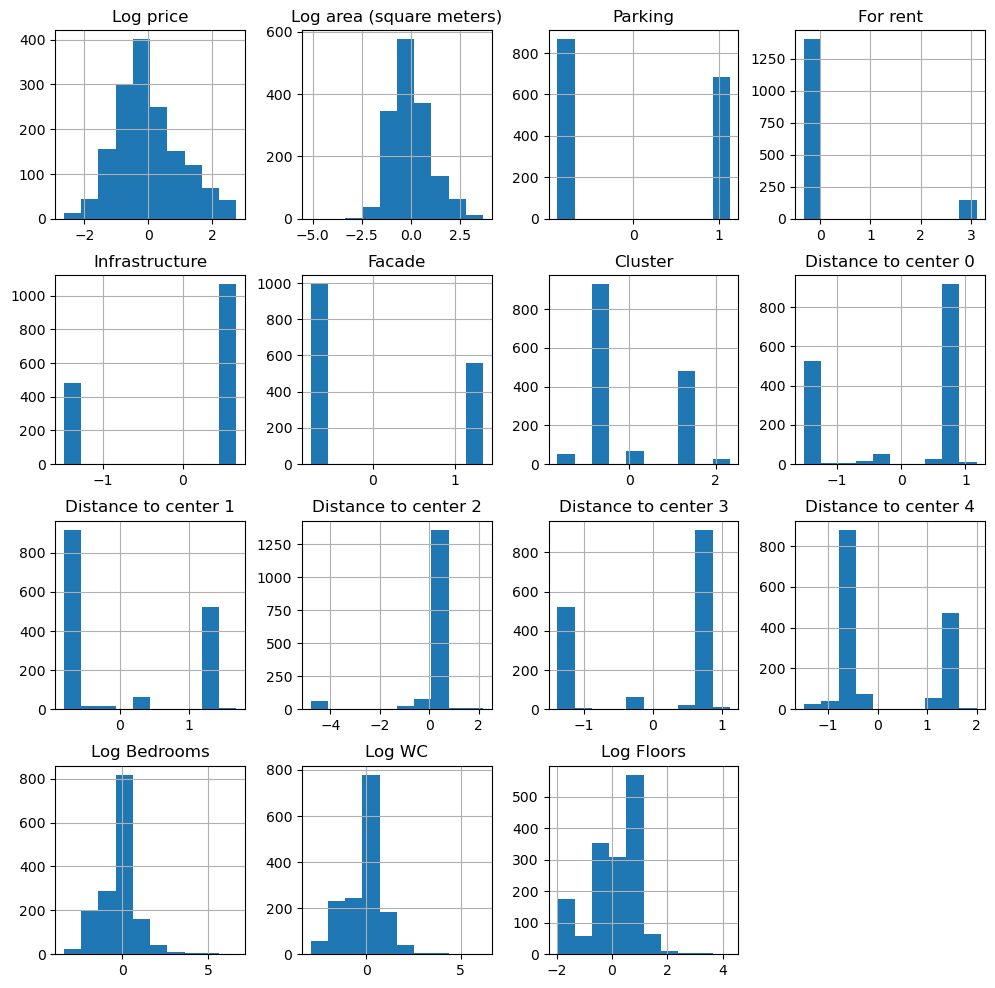

In [42]:
data.hist(figsize=(12, 12))
plt.show()

In [43]:
data.corr(numeric_only=True)

,Log price,Log area (square meters),Parking,For rent,Infrastructure,Facade,Cluster,Distance to center 0,Distance to center 1,Distance to center 2,Distance to center 3,Distance to center 4,Log Bedrooms,Log WC,Log Floors
Log price,1.000000,0.462722,0.061810,0.120315,-0.037839,0.248005,0.039625,-0.072188,0.068097,0.038903,-0.070497,0.072656,0.373913,0.360736,0.291458
Log area (square meters),0.462722,1.000000,-0.017268,0.103285,-0.039459,0.171600,-0.230719,0.251219,-0.248741,-0.129388,0.263268,-0.281902,0.208932,0.109690,-0.120007
Parking,0.061810,-0.017268,1.000000,-0.021804,-0.017113,-0.073111,0.132505,-0.105283,0.109396,0.102392,-0.115329,0.129904,0.084575,0.113994,0.184097
For rent,0.120315,0.103285,-0.021804,1.000000,0.033798,0.027358,-0.000923,0.012897,-0.012599,-0.064675,0.013826,-0.021361,0.140447,0.132904,0.048574
Infrastructure,-0.037839,-0.039459,-0.017113,0.033798,1.000000,-0.003601,0.064438,-0.057618,0.060434,0.011402,-0.060868,0.062141,0.015467,0.028895,0.035693
Facade,0.248005,0.171600,-0.073111,0.027358,-0.003601,1.000000,0.069307,-0.118155,0.116020,0.018637,-0.115383,0.113416,0.052121,0.039217,0.019560
Cluster,0.039625,-0.230719,0.132505,-0.000923,0.064438,0.069307,1.000000,-0.759284,0.791557,-0.139021,-0.787803,0.733151,0.176831,0.201061,0.308394
Distance to center 0,-0.072188,0.251219,-0.105283,0.012897,-0.057618,-0.118155,-0.759284,1.000000,-0.996471,0.155064,0.997747,-0.977031,-0.154053,-0.177125,-0.315863
Distance to center 1,0.068097,-0.248741,0.109396,-0.012599,0.060434,0.116020,0.791557,-0.996471,1.000000,-0.139890,-0.996856,0.978327,0.158114,0.181537,0.317153
Distance to center 2,0.038903,-0.129388,0.102392,-0.064675,0.011402,0.018637,-0.139021,0.155064,-0.139890,1.000000,0.121657,0.023779,-0.016006,0.005482,0.075472


In [44]:
data.corr()

,Log price,Log area (square meters),Parking,For rent,Infrastructure,Facade,Cluster,Distance to center 0,Distance to center 1,Distance to center 2,Distance to center 3,Distance to center 4,Log Bedrooms,Log WC,Log Floors
Log price,1.000000,0.462722,0.061810,0.120315,-0.037839,0.248005,0.039625,-0.072188,0.068097,0.038903,-0.070497,0.072656,0.373913,0.360736,0.291458
Log area (square meters),0.462722,1.000000,-0.017268,0.103285,-0.039459,0.171600,-0.230719,0.251219,-0.248741,-0.129388,0.263268,-0.281902,0.208932,0.109690,-0.120007
Parking,0.061810,-0.017268,1.000000,-0.021804,-0.017113,-0.073111,0.132505,-0.105283,0.109396,0.102392,-0.115329,0.129904,0.084575,0.113994,0.184097
For rent,0.120315,0.103285,-0.021804,1.000000,0.033798,0.027358,-0.000923,0.012897,-0.012599,-0.064675,0.013826,-0.021361,0.140447,0.132904,0.048574
Infrastructure,-0.037839,-0.039459,-0.017113,0.033798,1.000000,-0.003601,0.064438,-0.057618,0.060434,0.011402,-0.060868,0.062141,0.015467,0.028895,0.035693
Facade,0.248005,0.171600,-0.073111,0.027358,-0.003601,1.000000,0.069307,-0.118155,0.116020,0.018637,-0.115383,0.113416,0.052121,0.039217,0.019560
Cluster,0.039625,-0.230719,0.132505,-0.000923,0.064438,0.069307,1.000000,-0.759284,0.791557,-0.139021,-0.787803,0.733151,0.176831,0.201061,0.308394
Distance to center 0,-0.072188,0.251219,-0.105283,0.012897,-0.057618,-0.118155,-0.759284,1.000000,-0.996471,0.155064,0.997747,-0.977031,-0.154053,-0.177125,-0.315863
Distance to center 1,0.068097,-0.248741,0.109396,-0.012599,0.060434,0.116020,0.791557,-0.996471,1.000000,-0.139890,-0.996856,0.978327,0.158114,0.181537,0.317153
Distance to center 2,0.038903,-0.129388,0.102392,-0.064675,0.011402,0.018637,-0.139021,0.155064,-0.139890,1.000000,0.121657,0.023779,-0.016006,0.005482,0.075472


In [45]:
data.shape

(1548, 15)

# Linear Regression

In [46]:
X = data.drop("Log price", axis=1)
y = data["Log price"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=500)

In [47]:
print_ols_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:              Log price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     58.69
Date:                Tue, 18 Jun 2024   Prob (F-statistic):          1.11e-120
Time:                        16:48:25   Log-Likelihood:                -1198.2
No. Observations:                1048   AIC:                             2426.
Df Residuals:                    1033   BIC:                             2501.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [48]:
r_squared = pd.DataFrame()
r_squared["columns"] = X_train.columns
r_squared["r2"] = [calculate_r_squared(df=X_train, column=column) for column in X_train.columns]
r_squared

,columns,r2
0,Log area (square meters),0.271009
1,Parking,0.070016
2,For rent,0.035271
3,Infrastructure,0.011407
4,Facade,0.099993
5,Cluster,0.982428
6,Distance to center 0,0.999791
7,Distance to center 1,0.998649
8,Distance to center 2,0.713164
9,Distance to center 3,0.999802


In [49]:
X_train = process_data_using_vif(X_train)
return_vif(X_train)

,Features,VIF
0,Log area (square meters),1.32421
1,Parking,1.06408
2,For rent,1.03327
3,Infrastructure,1.00828
4,Facade,1.09916
5,Cluster,2.24459
6,Distance to center 2,1.10703
7,Distance to center 4,2.25182
8,Log Bedrooms,2.88275
9,Log WC,2.87768


In [50]:
print_ols_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:              Log price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     67.64
Date:                Tue, 18 Jun 2024   Prob (F-statistic):          1.10e-113
Time:                        16:48:25   Log-Likelihood:                -1221.3
No. Observations:                1048   AIC:                             2467.
Df Residuals:                    1036   BIC:                             2526.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [51]:
X_train.drop(columns="Parking", inplace=True)
print_ols_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:              Log price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     74.46
Date:                Tue, 18 Jun 2024   Prob (F-statistic):          1.31e-114
Time:                        16:48:25   Log-Likelihood:                -1221.3
No. Observations:                1048   AIC:                             2465.
Df Residuals:                    1037   BIC:                             2519.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [52]:
X_train.drop(columns="Log Bedrooms", inplace=True)
print_ols_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:              Log price   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     82.37
Date:                Tue, 18 Jun 2024   Prob (F-statistic):          4.37e-115
Time:                        16:48:25   Log-Likelihood:                -1222.5
No. Observations:                1048   AIC:                             2465.
Df Residuals:                    1038   BIC:                             2515.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [53]:
X_train.drop(columns="Cluster", inplace=True)
print_ols_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:              Log price   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     92.01
Date:                Tue, 18 Jun 2024   Prob (F-statistic):          2.45e-115
Time:                        16:48:25   Log-Likelihood:                -1224.2
No. Observations:                1048   AIC:                             2466.
Df Residuals:                    1039   BIC:                             2511.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [54]:
X_train.drop(columns="Infrastructure", inplace=True)
print_ols_summary(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:              Log price   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     104.4
Date:                Tue, 18 Jun 2024   Prob (F-statistic):          1.32e-115
Time:                        16:48:25   Log-Likelihood:                -1226.0
No. Observations:                1048   AIC:                             2468.
Df Residuals:                    1040   BIC:                             2508.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [55]:
columns_to_drop = list(set(data.columns) - set(X_train.columns))
columns_to_drop.remove("Log price")
columns_to_drop

['Log Bedrooms',
 'Distance to center 1',
 'Cluster',
 'Infrastructure',
 'Distance to center 3',
 'Distance to center 0',
 'Parking']

In [56]:
X_valid.columns

Index(['Log area (square meters)', 'Parking', 'For rent', 'Infrastructure',
       'Facade', 'Cluster', 'Distance to center 0', 'Distance to center 1',
       'Distance to center 2', 'Distance to center 3', 'Distance to center 4',
       'Log Bedrooms', 'Log WC', 'Log Floors'],
      dtype='object')

In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
X_valid.drop(columns=columns_to_drop, inplace=True)
y_predict = lin_reg.predict(X_valid)
mean_squared_error(y_valid, y_predict, squared=False)

0.7831401193839127

# Decision Tree

In [58]:
X = data.drop("Log price", axis=1)
y = data["Log price"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=500)

In [59]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [60]:
feature_importances = pd.DataFrame()
feature_importances["Features"] = X_train.columns
feature_importances["Importances"] = decision_tree.feature_importances_
feature_importances.sort_values("Importances", ascending=False, inplace=True)
feature_importances

,Features,Importances
0,Log area (square meters),0.342877
13,Log Floors,0.193395
8,Distance to center 2,0.079732
7,Distance to center 1,0.078362
6,Distance to center 0,0.068464
10,Distance to center 4,0.063338
9,Distance to center 3,0.048296
12,Log WC,0.036183
11,Log Bedrooms,0.035494
4,Facade,0.022574


In [61]:
columns_to_drop.extend(list(feature_importances["Features"])[-5:])

In [62]:
columns_to_drop = list(set(columns_to_drop))
columns_to_drop

['Log Bedrooms',
 'For rent',
 'Distance to center 1',
 'Cluster',
 'Facade',
 'Infrastructure',
 'Distance to center 3',
 'Distance to center 0',
 'Parking']

In [63]:
data.drop(columns=columns_to_drop, inplace=True)
data.to_csv("../data/complex_data.csv", sep="\t")

In [64]:
data = pd.read_csv("~/Downloads/train_set.csv", sep='\t')
data.head()

,ID,Log price (1 billion VND),Log area (square meters),Bedrooms,WC,Parking,For rent,Infrastructure,Facade,Number of floors,Log usable area (square meters),Latitude,Longitude,Cluster,Distance to center 0,Distance to center 1,Distance to center 2,Distance to center 3,Distance to center 4
0,971,1.446919,3.433987,3.0,4.0,0,0,1,0,5.0,5.043425,21.031116,105.786325,3,93.691747,1140.730341,597.162192,3.001564,1030.750816
1,1332,2.760010,3.784190,3.0,2.0,0,0,0,0,2.0,4.477337,16.070564,108.215084,2,555.615838,608.164938,14.826804,605.804125,430.590198
2,1477,1.294727,4.304065,4.0,4.0,1,0,1,1,2.0,4.997212,10.885533,106.768640,1,1107.692724,12.813838,599.604215,1131.537277,279.178235
3,119,1.702928,3.401197,2.0,2.0,0,0,0,1,1.8,3.988984,10.823005,106.635218,1,1114.596980,5.311304,609.915802,1137.275013,295.179398
4,611,1.722767,3.931826,2.0,2.0,1,0,0,0,2.0,4.624973,10.780409,106.644012,1,1119.331037,5.140908,614.255037,1142.070635,296.983248


In [65]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from train import ColumnDropper, LogTransformer

column_dropper = ColumnDropper(columns_to_drop=columns_to_drop)
log_transformer = LogTransformer()
std_scaler = StandardScaler()
pipeline = make_pipeline(log_transformer, column_dropper, std_scaler)
pipeline.fit(data)
with open("pipeline.pkl", "wb") as file:
    pickle.dump(pipeline, file)

In [66]:
data

,ID,Log price (1 billion VND),Log area (square meters),Bedrooms,WC,Parking,For rent,Infrastructure,Facade,Number of floors,...,Longitude,Cluster,Distance to center 0,Distance to center 1,Distance to center 2,Distance to center 3,Distance to center 4,Log Bedrooms,Log WC,Log Floors
0,971,1.446919,3.433987,3.0,4.0,0,0,1,0,5.0,...,105.786325,3,93.691747,1140.730341,597.162192,3.001564,1030.750816,1.098612,1.386294,1.609438
1,1332,2.760010,3.784190,3.0,2.0,0,0,0,0,2.0,...,108.215084,2,555.615838,608.164938,14.826804,605.804125,430.590198,1.098612,0.693147,0.693147
2,1477,1.294727,4.304065,4.0,4.0,1,0,1,1,2.0,...,106.768640,1,1107.692724,12.813838,599.604215,1131.537277,279.178235,1.386294,1.386294,0.693147
3,119,1.702928,3.401197,2.0,2.0,0,0,0,1,1.8,...,106.635218,1,1114.596980,5.311304,609.915802,1137.275013,295.179398,0.693147,0.693147,0.587787
4,611,1.722767,3.931826,2.0,2.0,1,0,0,0,2.0,...,106.644012,1,1119.331037,5.140908,614.255037,1142.070635,296.983248,0.693147,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,649,1.731656,5.252273,4.0,4.0,0,0,1,0,2.0,...,106.775040,1,1108.447360,12.872984,600.167106,1132.343876,279.007292,1.386294,1.386294,0.693147
1544,1452,0.717840,2.995732,2.0,3.0,0,0,1,0,3.0,...,106.675382,1,1112.656639,3.626609,606.937874,1135.684445,290.446564,0.693147,1.098612,1.098612
1545,939,1.609438,4.521789,4.0,4.0,0,0,0,0,2.0,...,106.797190,1,1112.683561,13.144318,603.702789,1136.752785,279.359962,1.386294,1.386294,0.693147
1546,428,1.504077,3.688879,4.0,3.0,0,0,1,0,4.0,...,105.766337,3,94.527766,1134.229829,591.924623,7.312113,1025.117221,1.386294,1.098612,1.386294


In [67]:
pipeline[1].columns_to_drop

['Log Bedrooms',
 'For rent',
 'Distance to center 1',
 'Cluster',
 'Facade',
 'Infrastructure',
 'Distance to center 3',
 'Distance to center 0',
 'Parking']

In [68]:
data.columns

Index(['ID', 'Log price (1 billion VND)', 'Log area (square meters)',
       'Bedrooms', 'WC', 'Parking', 'For rent', 'Infrastructure', 'Facade',
       'Number of floors', 'Log usable area (square meters)', 'Latitude',
       'Longitude', 'Cluster', 'Distance to center 0', 'Distance to center 1',
       'Distance to center 2', 'Distance to center 3', 'Distance to center 4',
       'Log Bedrooms', 'Log WC', 'Log Floors'],
      dtype='object')

In [69]:
data.shape

(1548, 22)